<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2 - Ames Housing Data and Kaggle Challenge - Part 2: Feature Selection, Modelling and Recommendations

### Lo kok Fu - DSIF 2

## Contents
1. Import Library
2. Import Cleaned Data
3. EDA
4. Features Selection
5. Modelling for 1st Feature selection set (10 most Important Features)
6. Modelling for 2nd Feature Selection set (50 most Important Features)
7. Modelling for 3rd Feature Selection set (20 most Important Features)
8. Test assumptions on the 3rd feature selection set model with Ridge Regression
9. Reccomendations and Conclusions
10. Export Data for Submission

### 1.  Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

### 2. Import Cleaned Data

In [2]:
# importing cleaned datasets
train_df = pd.read_csv('./datasets/train_clean.csv')
test_df = pd.read_csv('./datasets/test_clean.csv')

In [3]:
train_df.head()

,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Garage Type_Detchd,Garage Type_None,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,68.883003,13517,1,0,0,6,8,1976,2005,289.0,...,0,0,0,0,0,0,0,0,0,1
1,43.000000,11492,1,0,0,7,5,1996,1997,132.0,...,0,0,0,0,0,0,0,0,0,1
2,68.000000,7922,0,0,0,5,7,1953,2007,0.0,...,1,0,0,0,0,0,0,0,0,1
3,73.000000,9802,0,0,0,5,5,2006,2007,0.0,...,0,0,0,0,0,0,0,0,0,1
4,82.000000,14235,1,0,0,6,8,1900,1993,0.0,...,1,0,0,0,0,0,0,0,0,1


In [4]:
train_df.shape

(2045, 194)

In [5]:
test_df.head()

,Id,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,...,Garage Type_None,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,2658,69.000000,9142,0,0,0,6,8,1910,1950,...,0,0,0,0,0,0,0,0,0,1
1,2718,69.545961,9662,1,0,0,5,4,1977,1977,...,0,0,0,0,0,0,0,0,0,1
2,2414,58.000000,17104,1,0,0,7,5,2006,2006,...,0,0,0,0,0,0,1,0,0,0
3,1989,60.000000,8520,0,0,0,5,6,1923,2006,...,0,0,0,0,0,0,0,0,0,1
4,625,69.545961,9500,1,0,0,6,5,1963,1963,...,0,0,0,0,0,0,0,0,0,1


In [6]:
test_df.shape

(878, 186)

### 3. EDA

### 3.1 Plot heatmap of Features by Sale Price

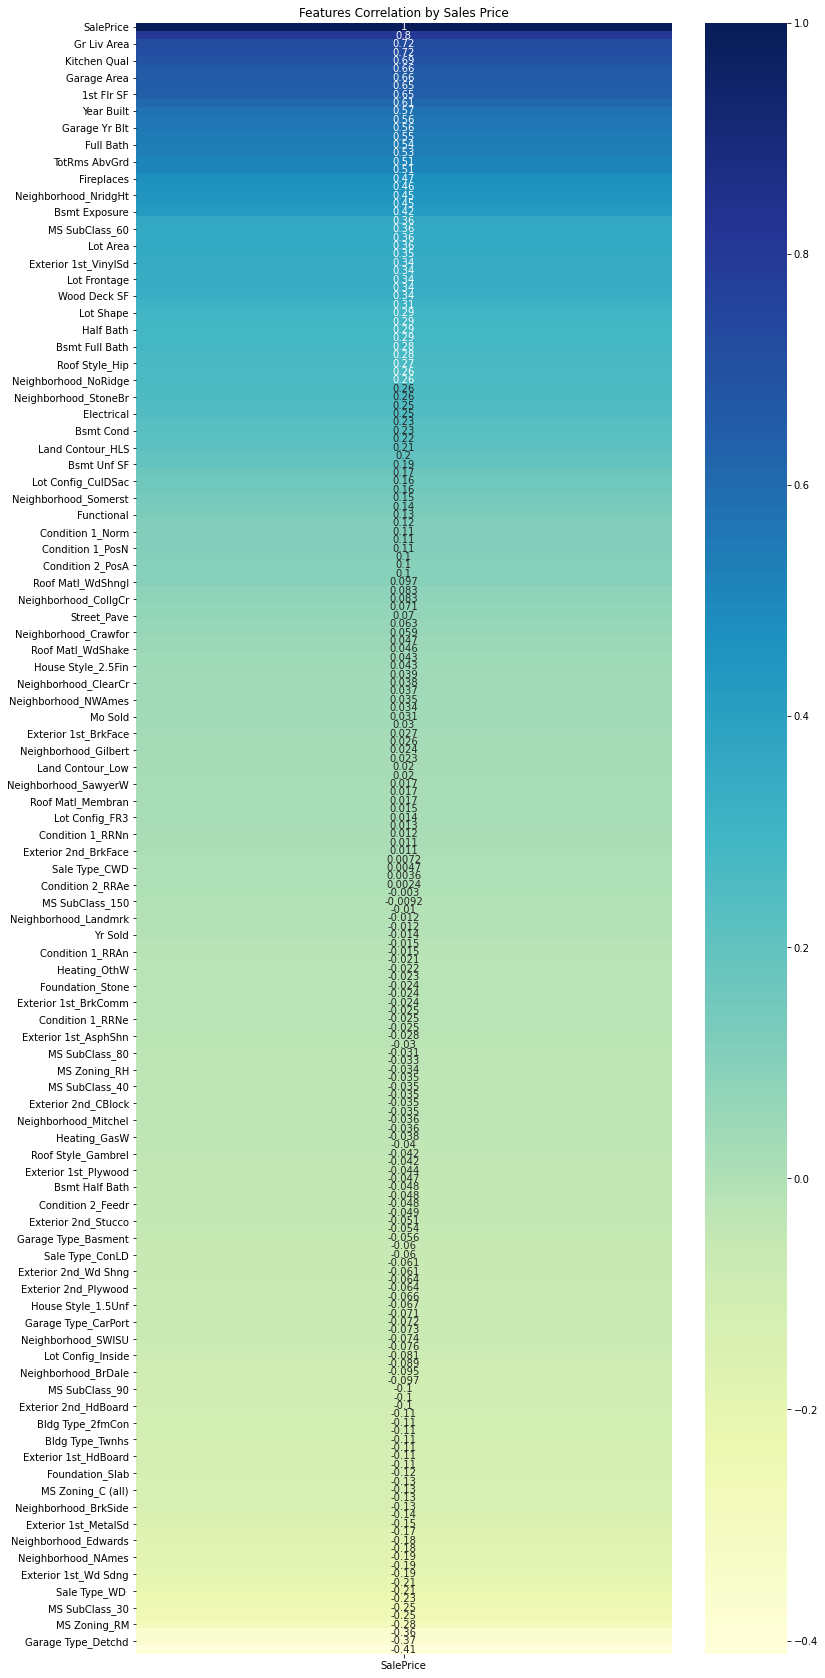

In [7]:
train_corr = train_df.corr()[['SalePrice']].sort_values('SalePrice', ascending = False)
plt.figure(figsize = (12,30))
sns.heatmap(train_corr,cmap="YlGnBu",annot = True)
plt.title('Features Correlation by Sales Price');

In [8]:
# identify top 10 positively correlation to SalePrice
top_corr = train_df.corr()['SalePrice'].sort_values().tail(11).index
top_corr = [col for col in top_corr if col != 'SalePrice' ]


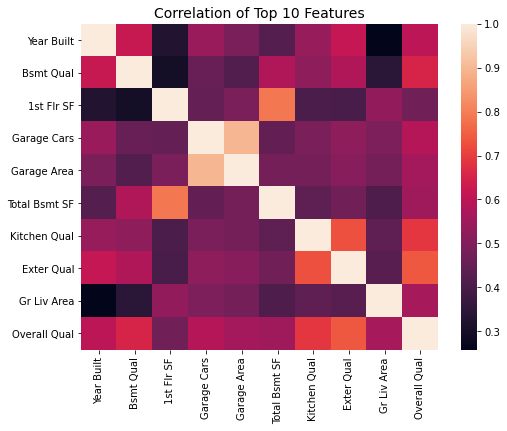

In [9]:
feat_cor = train_df[top_corr].corr()
plt.figure(figsize = (8,6))
sns.heatmap(feat_cor)
plt.title('Correlation of Top 10 Features', fontsize =14);

- We can obseve that Garage Cars and Garage Area are corelated to each other

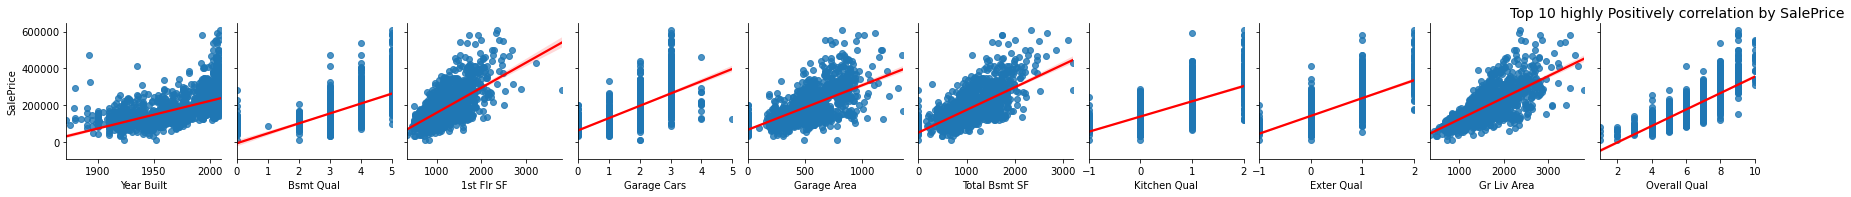

In [10]:
# plotting pairplot with Linear Regression Line to view Linear Regression relationship
g = sns.pairplot(train_df, x_vars=top_corr, y_vars=['SalePrice'], kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.title('Top 10 highly Positively correlation by SalePrice', fontsize = 14);

- We can observe strong positve Linear relationship in Year Built, 1st Flr SF, Garage Area, Garage Caars, Total Bsmt SF, Overall Qual and GR Liv Area.
- We have plotted out the list of 200 over features correlated with the Sale Price. however we may expect to have multi collinear features which can cancel out each other's influence in our prediction. Therefore we will need to conduct regularisation to curb this and select the best fit features for our modelling. Before we conduct regularisation, we will conduct a feature selection to select the most important features for our modelling.

## 4. Features Selection

### 4.1 Model Prep: Create our features matrix (`X`) and target vector (`y`)

In [11]:
features = [col for col in train_df if col != 'SalePrice']

X = train_df[features]
y = train_df['SalePrice']

### 4.2 Model Prep: Train, Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

### 4.3 1st Feature Model: Feature selection using Kbest method ( 10 Important Features)

- We will further remove the least important features columns to our y target(Sale Price). by selecting the 10 most important features to y using KBest(f_regression) method.

In [13]:
f_selector = SelectKBest(score_func = f_regression, k = 10)

In [14]:
f_selector.fit(X_train, y_train)

SelectKBest(score_func=<function f_regression at 0x0000018CFE2B28B0>)

In [15]:
X_train_fs = f_selector.transform(X_train)
X_test_fs = f_selector.transform(X_test)
f_imp= pd.Series(f_selector.scores_,index=X.columns).sort_values(ascending=False)
f_impt_10 = f_imp[:10]

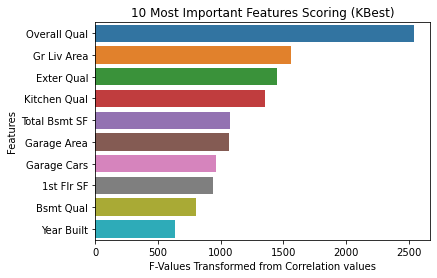

In [16]:
sns.barplot(x = f_impt_10, y = f_impt_10.index)
plt.title('10 Most Important Features Scoring (KBest)')
plt.ylabel('Features')
plt.xlabel('F-Values Transformed from Correlation values');

In [17]:
#dropping Garage cars as its corelated to Garage Area and moving the 11th feature up
f_impt_10 = f_imp[:11].drop(labels = 'Garage Cars')

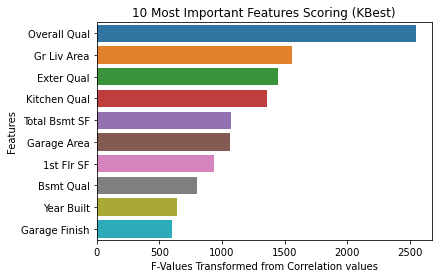

In [18]:
sns.barplot(x = f_impt_10, y = f_impt_10.index)
plt.title('10 Most Important Features Scoring (KBest)')
plt.ylabel('Features')
plt.xlabel('F-Values Transformed from Correlation values');

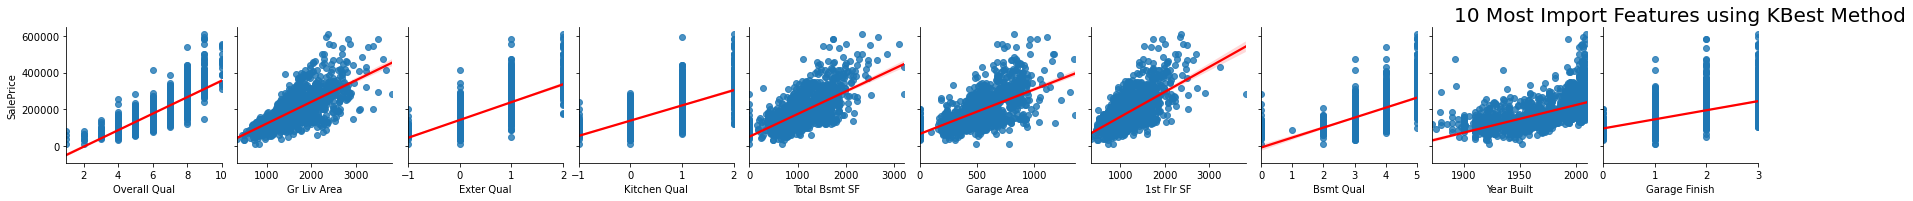

In [19]:
#plotting pairplots with Linear Regression line to overview Linear Regression relationship
f = sns.pairplot(data = train_df, y_vars = 'SalePrice', x_vars = f_impt_10.index, kind = 'reg', plot_kws ={'line_kws':{'color':'red'}} )
plt.title('10 Most Import Features using KBest Method', fontsize = 20);


- we can observe from the 10 most important features from kBest matches the top 10 features of the most positively correlated features
- from the pairplots, our Linear Regression lines fits in strongly into the plots as observed. This is evident of good linear regression model features
- The 10 most important feature selection using kBest result are similar to the top 10 correlation list. we can deduce that there is no need to run a kBest feature selection to select the important features. just selecting the list from the correlation list will suffice.

### 4.5  2nd Feature Model: Featuring using 50 most important features

- For our 2nd Feature Model, we will be employing 50 most important features for our 2nd set of modeling. this is for us to compare our modelling test score with the 1st Feature Model of 10 most important features and evaluate if which feature model scores more accurate.

In [20]:
f_selector = SelectKBest(score_func = f_regression, k = 50)

In [21]:
f_selector.fit(X_train, y_train)

SelectKBest(k=50, score_func=<function f_regression at 0x0000018CFE2B28B0>)

In [22]:
X_train_fs = f_selector.transform(X_train)
X_test_fs = f_selector.transform(X_test)
f_imp= pd.Series(f_selector.scores_,index=X.columns).sort_values(ascending=False)
f_impt_50 = f_imp[:50]

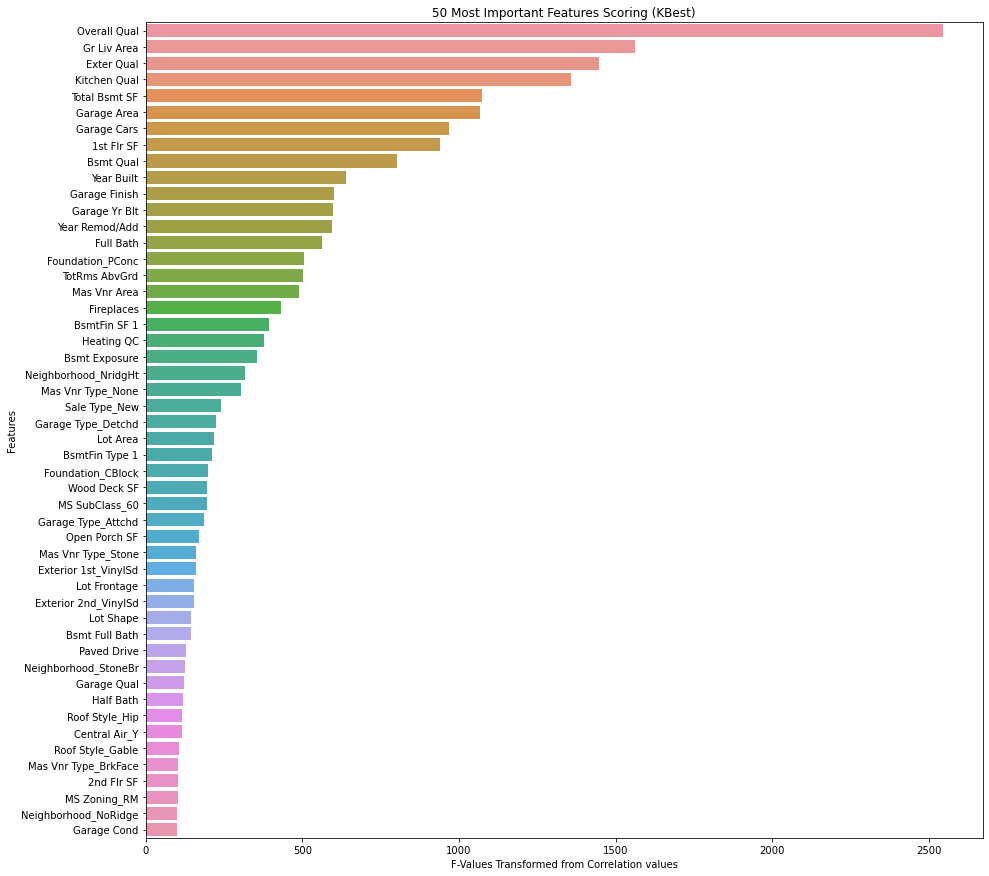

In [23]:
plt.figure(figsize=(15,15))
sns.barplot(x = f_impt_50, y = f_impt_50.index)

plt.title('50 Most Important Features Scoring (KBest)')
plt.ylabel('Features')
plt.xlabel('F-Values Transformed from Correlation values');

### 4.3 Final Features Selection
We have now decided on our features for our models:
- 1st feature Model utilising kBest method to identify the 10 most important feature
- 2nd Feature Model which is all the features after conducting data cleaning and featuring engineering.

we will then evaluate the best model for each feature selection and select the best scoring model and features for our prediction
    


In [24]:
# Instantating 10 most import features
X_10 = train_df[f_impt_10.index]
X_10.head()

,Overall Qual,Gr Liv Area,Exter Qual,Kitchen Qual,Total Bsmt SF,Garage Area,1st Flr SF,Bsmt Qual,Year Built,Garage Finish
0,6,1479,1,1,725.0,475.0,725,3,1976,2
1,7,2122,1,1,913.0,559.0,913,4,1996,2
2,5,1057,0,1,1057.0,246.0,1057,3,1953,1
3,5,1444,0,0,384.0,400.0,744,4,2006,3
4,6,1445,0,0,676.0,484.0,831,2,1900,1


In [25]:
# Instantating 50 most import features
X_50 = train_df[f_impt_50.index]
X_50.head()

,Overall Qual,Gr Liv Area,Exter Qual,Kitchen Qual,Total Bsmt SF,Garage Area,Garage Cars,1st Flr SF,Bsmt Qual,Year Built,...,Garage Qual,Half Bath,Roof Style_Hip,Central Air_Y,Roof Style_Gable,Mas Vnr Type_BrkFace,2nd Flr SF,MS Zoning_RM,Neighborhood_NoRidge,Garage Cond
0,6,1479,1,1,725.0,475.0,2.0,725,3,1976,...,3,1,0,1,1,1,754,0,0,3
1,7,2122,1,1,913.0,559.0,2.0,913,4,1996,...,3,1,0,1,1,1,1209,0,0,3
2,5,1057,0,1,1057.0,246.0,1.0,1057,3,1953,...,3,0,0,1,1,0,0,0,0,3
3,5,1444,0,0,384.0,400.0,2.0,744,4,2006,...,3,1,0,1,1,0,700,0,0,3
4,6,1445,0,0,676.0,484.0,2.0,831,2,1900,...,3,0,0,1,1,0,614,0,0,3


## 5. Modelling 1st Feature Selection Set (10 Most Important Features)

### 5.1 1st Modelling Model Prep: 10 most import features

In [26]:
X = X_10
y = train_df['SalePrice']

### 5.2 Model Prep: Train/test split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

### 5.3 Model Prep: Instantiate Regression models

In [28]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

### 5.4 Fitting and Evaluate models on Training  and Test data
- conducting fitting and Prediction for both X_train and X_test for evaluation.
- Do NOT fit  on the test data
- we will be use MSE as metric to evalute our scores. the lower the better

#### 5.4.1 Linear Regression

In [29]:
# fitting lr to train set
lr.fit(X_train, y_train)
lr_scores = cross_val_score(lr, X_train, y_train, cv = 5)
print(lr_scores.mean())

0.8435296045815923


In [30]:
# evaluate MSE for train set
y_train_pred = lr.predict(X_train)
lr_MSE_train = mean_squared_error(y_train, y_train_pred)
# evaluate MSE for test set
y_test_pred = lr.predict(X_test)
lr_MSE_test = mean_squared_error(y_test, y_test_pred)
lr_RMSE = np.sqrt(lr_MSE_test)

In [31]:
# print results
print(f' Linear Regression MSE Train Score is: {lr_MSE_train}')
print(f' MSE Test Score is: {lr_MSE_test}')
print(f' RMSE score is :{lr_RMSE}')

 Linear Regression MSE Train Score is: 956542124.8176463
 MSE Test Score is: 1007129737.9943645
 RMSE score is :31735.307435006274


In [32]:
# check for overfitting
lr_MSE_diff = abs(1-(lr_MSE_train/lr_MSE_test))

print(lr_MSE_diff*100, "%") # if this is between 1-2%, then no overfitting.

5.022949007290789 %


#### 5.4.2 Ridge

In [33]:
#fitting ridge into train set 
ridge.fit(X_train, y_train)
ridge_scores = cross_val_score(ridge, X_train, y_train, cv = 5)
print(ridge_scores.mean())

0.8435448853575295


In [34]:
# evaluate MSE for Train set
y_train_pred = ridge.predict(X_train)
rig_MSE_train = mean_squared_error(y_train, y_train_pred)

# evaluate MSE for test set
y_test_pred = ridge.predict(X_test)
rig_MSE_test = mean_squared_error(y_test, y_test_pred)
rig_RMSE = np.sqrt(rig_MSE_test)

In [35]:
# print results
print(f' Ridge MSE Train Score is: {rig_MSE_train}')
print(f' MSE Test Score is: {rig_MSE_test}')
print(f' RMSE score is :{rig_RMSE}')

 Ridge MSE Train Score is: 956542932.0060252
 MSE Test Score is: 1007038484.9975044
 RMSE score is :31733.86968205271


In [36]:
# check for overfitting
rig_MSE_diff = abs(1-(rig_MSE_train/rig_MSE_test))

print(rig_MSE_diff*100, "%") # if this is between 1-2%, then no overfitting.

5.014262487853605 %


#### 5.4.3 Lasso

In [37]:
lasso.fit(X_train, y_train)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv = 5)
print(lasso_scores.mean())

0.8435298663383598


In [38]:
# evaluate MSE for train set
y_train_pred = lasso.predict(X_train)
lasso_MSE_train = mean_squared_error(y_train, y_train_pred)

# evaluate MSE for test set
y_test_pred = lasso.predict(X_test)
lasso_MSE_test = mean_squared_error(y_test, y_test_pred)
lasso_RMSE = np.sqrt(lasso_MSE_test)

# print results
print(f' lasso MSE Train Score is: {lasso_MSE_train}')
print(f' MSE Test Score is: {lasso_MSE_test}')
print(f' RMSE score is :{lasso_RMSE}')

 lasso MSE Train Score is: 956542133.9047121
 MSE Test Score is: 1007122510.4596802
 RMSE score is :31735.19356266289


In [39]:
# check for overfitting
lasso_MSE_diff = abs(1-(lasso_MSE_train/lasso_MSE_test))

print(lasso_MSE_diff*100, "%") # if this is between 1-2%, then no overfitting.

5.022266509749818 %


| Model | R2 train Score | MSE Train Score | MSE Test Score | RMSE Score | Overfit |
|---|---|---|---|---| --- |
| Linear Regression | 0.8435296045815923 | 956542124.8176463 | 1007038484.9975044 | 31735.307435006274 |5.02294900729078 %|
| Ridge | 0.8435448853575295| 956542932.0060252 | 1007038484.9975044| 31733.86968205271 |5.014262487853605 %|
| Lasso | 0.8435298663383598| 956542133.9047121 | 1007122510.4596802 | 31735.19356266289 |5.022266509749818 %|

- From the 3 results generated. Basing on the MSE score, Ridge gives us the best scoring MSE results with the least overfitting result.
- we will proceed to use Ridge for our Linear Regression. however there is is slight overfitting of variables. Hence we will conduct Regularization/hypertunning with k-fold cv using gridsearchCV to find the optimal parameters for the regression model to reduce overfitting.

### 5.5 Linear Regression with Regularization, and k-fold cross-validation

**Approach: Linear Regression with Ridge regularisation, 5-fold cross validation. Use MSE**

In [40]:
# State the parameters for ridge regularisation
# we want to go through 1000 different alpha values
parameters = {
                'alpha': [x/100 for x in range(1000)]
             }

# Instantiate the model
ridge = Ridge()

# Instantiate Gridsearch (use previous instantiated parameters and model)
gs_ridge = GridSearchCV(ridge, parameters, 
                     scoring='neg_mean_squared_error', 
                     cv=5, verbose=1, n_jobs=-1)

In [41]:
# Fit 5000 models on the training data:
#    5-fold cross-validation. Each fold has to test out 1000 different alpha values.
#    Find the best alpha value (and corresponding coefficients) out of the 5000. 

gs_ridge.fit(X_train, y_train);

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [42]:
# Best parameter for ridge
print(gs_ridge.best_params_)

{'alpha': 9.99}


In [43]:
# now we retrain using the best parameter for ridge alpha on the entire training data
best_model = Ridge(alpha=9.99)
best_model.fit(X_train, y_train)

Ridge(alpha=9.99)

In [44]:
# evaluate MSE for training set
y_train_pred = best_model.predict(X_train)
MSE_train = mean_squared_error(y_train, y_train_pred)

# evaluate MSE for test set
y_test_pred = best_model.predict(X_test)
MSE_test = mean_squared_error(y_test, y_test_pred)
RMSE = np.sqrt(MSE_test)


In [45]:
# print results
print(f' Ridge MSE Train Score is: {MSE_train}')
print(f' MSE Test Score is: {MSE_test}')
print(f' RMSE score is :{RMSE}')

 Ridge MSE Train Score is: 956618263.0709639
 MSE Test Score is: 1006292331.3752158
 RMSE score is :31722.111080052913


In [46]:
# check for overfitting
MSE_diff = abs(1-(MSE_train/MSE_test))

print(MSE_diff*100, "%") 

4.936345707451284 %


- After hyptertunning, the MSE and RMSE score using the best parameters fared slighty better. 

## 6. Modelling 2nd Feature Selection Set (50 Most Important Features)

### 6.1 2nd Modelling Model Prep: 50 most import features

In [47]:
X_50 = X_50
y = train_df['SalePrice']

### 6.2 Model Prep: Train/test split

In [48]:
X50_train, X50_test, y_train, y_test = train_test_split(X_50, y, test_size = 0.3, random_state=42)

### 6.3 Model Prep: Instantiate Regression models

In [49]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

### 6.4 Fitting and Evaluate models on Training  and Test data
- conducting fitting and Prediction for both X_train and X_test for evaluation.
- Do NOT fit  on the test data
- we will be use MSE as metric to evalute our scores. the lower the better

### 6.4.1 linear Regression

In [50]:
# fitting lr to train set and getting cross val train score
lr.fit(X50_train, y_train)
lr_scores = cross_val_score(lr, X50_train, y_train, cv = 5)
print(lr_scores.mean())

# cross val test scores
lr_scores = cross_val_score(lr, X50_test, y_test, cv = 5)
lr_scores.mean()

0.8907521356069867


0.8871886550751762

In [51]:
# evaluate MSE for train set
y_train_pred = lr.predict(X50_train)
lr_MSE_train = mean_squared_error(y_train, y_train_pred)
# evaluate MSE for test set
y_test_pred = lr.predict(X50_test)
lr_MSE_test = mean_squared_error(y_test, y_test_pred)
lr_RMSE = np.sqrt(lr_MSE_test)

# print results
print(f' Linear Regression MSE Train Score is: {lr_MSE_train}')
print(f' MSE Test Score is: {lr_MSE_test}')
print(f' RMSE score is :{lr_RMSE}')

 Linear Regression MSE Train Score is: 598675089.6729249
 MSE Test Score is: 690867096.6937839
 RMSE score is :26284.350794603695


In [52]:
# check for overfitting
lr_MSE_diff = abs(1-(lr_MSE_train/lr_MSE_test))

print(lr_MSE_diff*100, "%") # if this is between 1-2%, then no overfitting.

13.344391050326966 %


### 6.4.2 Ridge

In [53]:
#fitting ridge into train set 
ridge.fit(X50_train, y_train)
ridge_scores = cross_val_score(ridge, X50_train, y_train, cv = 5)
print(ridge_scores.mean())

0.8909727157889357


In [54]:
# evaluate MSE for Train set
y_train_pred = ridge.predict(X50_train)
rig_MSE_train = mean_squared_error(y_train, y_train_pred)

# evaluate MSE for test set
y_test_pred = ridge.predict(X50_test)
rig_MSE_test = mean_squared_error(y_test, y_test_pred)
rig_RMSE = np.sqrt(rig_MSE_test)

# print results
print(f' Ridge MSE Train Score is: {rig_MSE_train}')
print(f' MSE Test Score is: {rig_MSE_test}')
print(f' RMSE score is :{rig_RMSE}')

 Ridge MSE Train Score is: 598827277.0070345
 MSE Test Score is: 690959951.0878743
 RMSE score is :26286.117078942534


In [55]:
# check for overfitting
rig_MSE_diff = abs(1-(rig_MSE_train/rig_MSE_test))

print(rig_MSE_diff*100, "%") # if this is between 1-2%, then no overfitting.

13.334010739085889 %


### 6.4.3 Lasso

In [56]:
lasso.fit(X50_train, y_train)
lasso_scores = cross_val_score(lasso, X50_train, y_train, cv = 5)
print(lasso_scores.mean())

0.8907826934505841


In [57]:
# evaluate MSE for train set
y_train_pred = lasso.predict(X50_train)
lasso_MSE_train = mean_squared_error(y_train, y_train_pred)

# evaluate MSE for test set
y_test_pred = lasso.predict(X50_test)
lasso_MSE_test = mean_squared_error(y_test, y_test_pred)
lasso_RMSE = np.sqrt(lasso_MSE_test)

# print results
print(f' lasso MSE Train Score is: {lasso_MSE_train}')
print(f' MSE Test Score is: {lasso_MSE_test}')
print(f' RMSE score is :{lasso_RMSE}')

 lasso MSE Train Score is: 598677719.3550985
 MSE Test Score is: 691046555.0431108
 RMSE score is :26287.76435992819


In [58]:
# check for overfitting
lasso_MSE_diff = abs(1-(lasso_MSE_train/lasso_MSE_test))

print(lasso_MSE_diff*100, "%") # if this is between 1-2%, then no overfitting.

13.366514168101151 %


| Model | R2 Score | MSE Train Score | MSE Test Score | RMSE Score | Overfit|
|---|---|---|---|---| --- |
| Linear Regression | 0.8907521356069867 | 598675089.6729249 | 690867096.6937839 | 26284.350794603695 | 13.344391050326966 %|
| Ridge | 0.8909727157889357 | 598827277.0070345 | 690959951.0878743 | 26286.117078942534 | 13.334010739085889 % |
| Lasso | 0.8907826934505841 | 598677719.3550985 | 691046555.0431108 | 26287.76435992819 | 13.366514168101151 %|

- From the results generated. Basing on the MSE score, LR gives us the best scoring MSE results and ridge gives us the least overfitting result amongst the 3.
- the 3 models seems to be giving us poorer results than the 10 feature model.though the RMSE score has reduced but the overfitness has increased drastically.
- We will proceed to use Ridge for our Linear Regression. however there is is indications of overfitting of variables. Hence we will conduct Regularization/hypertunning with k-fold cv using gridsearchCV to find the optimal parameters for the regression model to reduce overfitting.

### 6.5 Linear Regression with Regularization, and k-fold cross-validation

**Approach: Linear Regression with Ridge regularisation, 5-fold cross validation. Use MSE**

In [59]:
# State the parameters for ridge regularisation
# we want to go through 1000 different alpha values
parameters = {
                'alpha': [x/100 for x in range(1000)]
             }

# Instantiate the model
ridge = Ridge()

# Instantiate Gridsearch (use previous instantiated parameters and model)
gs_ridge = GridSearchCV(ridge, parameters, 
                     scoring='neg_mean_squared_error', 
                     cv=5, verbose=1, n_jobs=-1)

# Fit 5000 models on the training data:
#    5-fold cross-validation. Each fold has to test out 1000 different alpha values.
#    Find the best alpha value (and corresponding coefficients) out of the 5000. 

gs_ridge.fit(X50_train, y_train);

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [60]:
# Best parameter for ridge
print(gs_ridge.best_params_)

{'alpha': 3.42}


In [61]:
# now we retrain using the best parameter for ridge alpha on the entire training data
best_model50 = Ridge(alpha=3.42)
best_model50.fit(X50_train, y_train)

# evaluate MSE for training set
y_train_pred50 = best_model50.predict(X50_train)
MSE50_train = mean_squared_error(y_train, y_train_pred50)

# evaluate MSE for test set
y_test_pred50 = best_model50.predict(X50_test)
MSE50_test = mean_squared_error(y_test, y_test_pred50)
# RMSE
RMSE50 = np.sqrt(MSE50_test)


In [62]:
# print results
print(f' Ridge MSE Train Score is: {MSE50_train}')
print(f' MSE Test Score is: {MSE50_test}')
print(f' RMSE score is :{RMSE50}')

 Ridge MSE Train Score is: 599915565.0728122
 MSE Test Score is: 690937098.5505824
 RMSE score is :26285.682387006476


In [63]:
# check for overfitting
MSE_diff = abs(1-(MSE50_train/MSE50_test))

print(MSE_diff*100, "%") 

13.173635294545793 %


- From the results observed. the RMSE scores increased as compared with the ridge without the best parameter for alpha. the overfitting Scores only decreased slightly. these observations indicates that overfitting or multi-correality issues. we will attempt to reduce the features to 25 and review the scores.  

## 7. Model 3rd Modelling feature selection with 20 most important features

In [64]:
# instantiate 25 most import features. 
f_impt_20 = f_imp[:20]
X_20 = train_df[f_impt_20.index]
#check
X_20.head()

,Overall Qual,Gr Liv Area,Exter Qual,Kitchen Qual,Total Bsmt SF,Garage Area,Garage Cars,1st Flr SF,Bsmt Qual,Year Built,Garage Finish,Garage Yr Blt,Year Remod/Add,Full Bath,Foundation_PConc,TotRms AbvGrd,Mas Vnr Area,Fireplaces,BsmtFin SF 1,Heating QC
0,6,1479,1,1,725.0,475.0,2.0,725,3,1976,2,1976.0,2005,2,0,6,289.0,0,533.0,2
1,7,2122,1,1,913.0,559.0,2.0,913,4,1996,2,1997.0,1997,2,1,8,132.0,1,637.0,2
2,5,1057,0,1,1057.0,246.0,1.0,1057,3,1953,1,1953.0,2007,1,0,5,0.0,0,731.0,0
3,5,1444,0,0,384.0,400.0,2.0,744,4,2006,3,2007.0,2007,2,1,7,0.0,0,0.0,1
4,6,1445,0,0,676.0,484.0,2.0,831,2,1900,1,1957.0,1993,2,1,6,0.0,0,0.0,0


### 7.1 2nd Modelling Model Prep: 20 most import features

In [65]:
X_20 = X_20
y = train_df['SalePrice']

### 7.2 Model Prep: Train/test split

In [66]:
X20_train, X20_test, y_train, y_test = train_test_split(X_20, y,test_size = 0.3, random_state=42)

###  7.3 Model Prep: Instantiate Regression models

In [67]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

### 7.4 Fitting and Evaluate models on Training and Test data
- conducting fitting and Prediction for both X_train and X_test for evaluation.
- Do NOT fit on the test data
- we will be use MSE as metric to evalute our scores. the lower the better

### 7.4.1 linear Regression

In [68]:
# fitting lr to train set 
lr.fit(X20_train, y_train)

# generating cross val train score
lr_scores = cross_val_score(lr, X20_train, y_train, cv = 5)
print(lr_scores.mean())

# cross val test scores
lr_scores = cross_val_score(lr, X20_test, y_test, cv = 5)
print(lr_scores.mean())


0.8638365815565299
0.870609884653951


In [69]:
# evaluate MSE for train set
y_train_pred = lr.predict(X20_train)
lr_MSE_train = mean_squared_error(y_train, y_train_pred)
# evaluate MSE for test set
y_test_pred = lr.predict(X20_test)
lr_MSE_test = mean_squared_error(y_test, y_test_pred)
lr_RMSE = np.sqrt(lr_MSE_test)

# print results
print(f' Linear Regression MSE Train Score is: {lr_MSE_train}')
print(f' MSE Test Score is: {lr_MSE_test}')
print(f' RMSE score is :{lr_RMSE}')

 Linear Regression MSE Train Score is: 812215382.4328063
 MSE Test Score is: 803239944.2010149
 RMSE score is :28341.488037875057


In [70]:
# check for overfitting
lr_MSE_diff = abs(1-(lr_MSE_train/lr_MSE_test))

print(lr_MSE_diff*100, "%") # if this is between 1-2%, then no overfitting.

1.117404369216124 %


### 7.4.2 Ridge

In [71]:
#fitting ridge into train set 
ridge.fit(X20_train, y_train)
# generating cross val train score
ridge_scores = cross_val_score(ridge, X20_train, y_train, cv = 5)
print(ridge_scores.mean())
# generating cross val test score
ridge_scores = cross_val_score(ridge, X20_test, y_test, cv = 5)
print(ridge_scores.mean())

0.8638568746161646
0.8706675023086767


In [72]:
# evaluate MSE for Train set
y_train_pred = ridge.predict(X20_train)
rig_MSE_train = mean_squared_error(y_train, y_train_pred)

# evaluate MSE for test set
y_test_pred = ridge.predict(X20_test)
rig_MSE_test = mean_squared_error(y_test, y_test_pred)
# RMSE
rig_RMSE = np.sqrt(rig_MSE_test)

# print results
print(f' Ridge MSE Train Score is: {rig_MSE_train}')
print(f' MSE Test Score is: {rig_MSE_test}')
print(f' RMSE score is :{rig_RMSE}')

 Ridge MSE Train Score is: 812216450.6980302
 MSE Test Score is: 803219305.4287509
 RMSE score is :28341.12392670324


In [73]:
# check for overfitting
rig_MSE_diff = abs(1-(rig_MSE_train/rig_MSE_test))

print(rig_MSE_diff*100, "%") # if this is between 1-2%, then no overfitting.

1.1201355854459694 %


### 7.4.2 Lasso

In [74]:
#fitting lasso into train set
lasso.fit(X20_train, y_train)
# generating cross val train score
lasso_scores = cross_val_score(lasso, X20_train, y_train, cv = 5)
print(lasso_scores.mean())
# generating cross val test score
lasso_scores = cross_val_score(lasso, X20_test, y_test, cv = 5)
print(lasso_scores.mean())

0.863837111822267
0.8706126455853006


In [75]:
# evaluate MSE for train set
y_train_pred = lasso.predict(X20_train)
lasso_MSE_train = mean_squared_error(y_train, y_train_pred)

# evaluate MSE for test set
y_test_pred = lasso.predict(X20_test)
lasso_MSE_test = mean_squared_error(y_test, y_test_pred)
lasso_RMSE = np.sqrt(lasso_MSE_test)

# print results
print(f' lasso MSE Train Score is: {lasso_MSE_train}')
print(f' MSE Test Score is: {lasso_MSE_test}')
print(f' RMSE score is :{lasso_RMSE}')

 lasso MSE Train Score is: 812215423.5699631
 MSE Test Score is: 803252445.9456915
 RMSE score is :28341.7085925618


In [76]:
# check for overfitting
lasso_MSE_diff = abs(1-(lasso_MSE_train/lasso_MSE_test))

print(lasso_MSE_diff*100, "%") # if this is between 1-2%, then no overfitting.

1.115835708874724 %


| Model | R2 Train Score | R2 Test Score | MSE Train Score | MSE Test Score | RMSE Score | overfitting |
|---|---|---|---|---|---|---|
| Linear Regression | 0.8638365815565299 | 0.870609884653951 | 812215382.4328063 | 803239944.2010149 | 28341.488037875057 | 1.117404369216124 % |
| Ridge | 0.8638568746161646 | 0.8706675023086767 | 812216450.6980302 | 803219305.4287509 | 28341.12392670324 | 1.1201355854459694 % |
| Lasso | 0.863837111822267 | 0.8706126455853006 | 812215423.5699631 | 803252445.9456915 | 28341.7085925618 | 1.115835708874724 % |

- From the scores generated with the reduced features to 20, the RMSE scores increased to 28000s from 26000s. However the overfitness for all models decreased to the 1% +/- range which are more ideal. this indicates that our features are well fitted with these features.
- The Ridge RMSE score performed the best amongst the tree though its overfitting is the highest but it is well between the range of not overfitting.
- Moving forward, we will further conduct a lr with ridge regularisation with hypertunning utilising the GridCV to obtain the best parameter to further observe if we are able to generate better RMSE score.

### 7.5 Linear Regression with Regularization, and k-fold cross-validation

**Approach: Linear Regression with Ridge regularisation, 5-fold cross validation. Use MSE**

In [77]:
# State the parameters for ridge regularisation
# we want to go through 1000 different alpha values
parameters = { 'alpha': [x/100 for x in range(1000)] }


# Instantiate Gridsearch (use previous instantiated parameters and model)
gs_ridge = GridSearchCV(ridge, parameters, 
                     scoring='neg_mean_squared_error', 
                     cv=5, verbose=1, n_jobs=-1)

# Fit 5000 models on the training data:
#    5-fold cross-validation. Each fold has to test out 1000 different alpha values.
#    Find the best alpha value (and corresponding coefficients) out of the 5000. 

gs_ridge.fit(X20_train, y_train);

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [78]:
# Best parameter for ridge
print(gs_ridge.best_params_)

{'alpha': 9.99}


In [79]:
# now we retrain using the best parameter for ridge alpha on the entire training data
best_model20 = Ridge(alpha=9.99)
best_model20.fit(X20_train, y_train)

# evaluate MSE for training set
y_train_pred20 = best_model20.predict(X20_train)
MSE20_train = mean_squared_error(y_train, y_train_pred20)

# evaluate MSE for test set
y_test_pred20 = best_model20.predict(X20_test)
MSE20_test = mean_squared_error(y_test, y_test_pred20)
RMSE20 = np.sqrt(MSE20_test)


In [80]:
# print results
print(f' Ridge MSE Train Score is: {MSE20_train}')
print(f' MSE Test Score is: {MSE20_test}')
print(f' RMSE score is :{RMSE20}')

 Ridge MSE Train Score is: 812314766.4418072
 MSE Test Score is: 803102497.2499146
 RMSE score is :28339.063097602833


In [81]:
# check for overfitting
MSE_diff = abs(1-(MSE20_train/MSE20_test))

print(MSE_diff*100, "%") 

1.1470851134741 %


From the scores above, the LR with Ridge(best parameter, alpha = 9.99) regularisation perfomed better. the  MSE scores decreased slightly as what We are aiming for the MSE scores to decrease. variables are also fitted well. Henceforth,  for the 20 features model, we will select the ridge regression with no alpha parameters inputed which performed the best with no overfitting results.

### 7.6 Model Selection

| Features Selection | Model | MSE Train Score | MSE Test Score | RMSE Score | overfitting |
|---|---|---|---|---|---|
| 10 | Ridge(alpha = 9.99) |  956618263.0709639 | 1006292331.3752158 | 31722.111080052913 | 4.936345707451284 % |
| 20 | Ridge(alpha = 9.9) | 812314766.4418072 | 803102497.2499146 | 28339.063097602833 | 1.1470851134741 % |
| 50 | Ridge(alpha = 3.42) | 599915565.0728122 | 690937098.5505824 | 26285.682387006476 | 13.173635294545793 % |

- We choose the 20 features, Ridge regression (alpha = 9.9) model
- From the results above of the 3 best modeling test from each phases we conducted, we assessed that the model with 20 features and using the ridge regularisation (alpha 9.99) gives us the best RMSE scoring with ideal non overfitting of variables in the linear regression model.
- Even though the 50 features selection gave us better RMSE scoring results, the data is overfitted significantly more than the ideal 20 features selection. therefore we omitted this model out.

### 8. Test assumptions on 20 Features Model with Ridge Regression

In [82]:
# now we retrain using the best parameter for ridge alpha on the entire training data
best_model20 = Ridge(alpha=9.99)
best_model20.fit(X20_train, y_train)

# evaluate MSE for training set
y_train_pred20 = best_model20.predict(X20_train)
MSE20_train = mean_squared_error(y_train, y_train_pred20)

# evaluate MSE for test set
y_test_pred20 = best_model20.predict(X20_test)
MSE20_test = mean_squared_error(y_test, y_test_pred20)
RMSE20 = np.sqrt(MSE20_test)

# print results
print(f' Ridge MSE Train Score is: {MSE20_train}')
print(f' MSE Test Score is: {MSE20_test}')
print(f' RMSE score is :{RMSE20}')

 Ridge MSE Train Score is: 812314766.4418072
 MSE Test Score is: 803102497.2499146
 RMSE score is :28339.063097602833


#### 8.1 Coefficent of Features

In [83]:
# Create Datframe for coefficent of the 20 features
feat_10 = pd.DataFrame(best_model20.coef_, X_20.columns)
# coefficient of features value
feat_10.rename(columns = {0: 'Coefficent'}, inplace = True)
#sort the values
feat_10 = feat_10.sort_values(by = ['Coefficent'])
feat_10

,Coefficent
Full Bath,-4867.468518
Garage Cars,-3123.127022
Garage Yr Blt,-52.580725
1st Flr SF,12.769768
Total Bsmt SF,15.345371
BsmtFin SF 1,23.879675
Mas Vnr Area,28.444922
Garage Area,45.366014
Gr Liv Area,51.632990
Year Built,62.773473


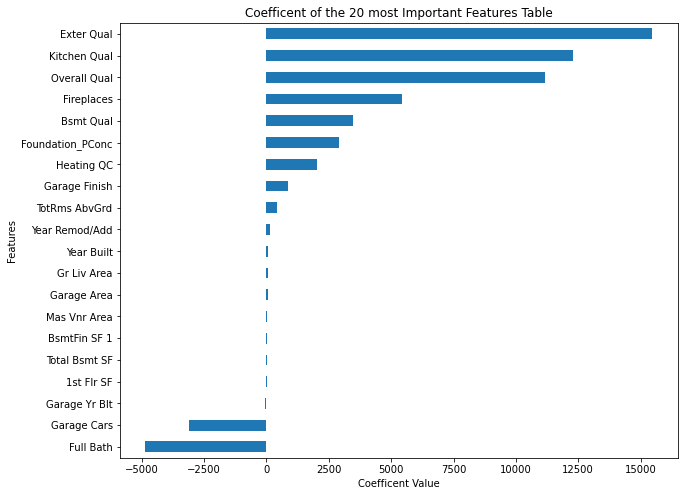

In [84]:

feat_10.plot(kind = 'barh', figsize = (10,8), legend = None)
plt.title('Coefficent of the 20 most Important Features Table', fontsize = 12)
plt.xlabel('Coefficent Value')
plt.ylabel('Features');

The above are the coefficent results of the features. It is interpretable for every grade/numerical value increase or decrease of the feature, the Sale price will increase or decrease by the coefficent value.

#### 8.2 Residual 

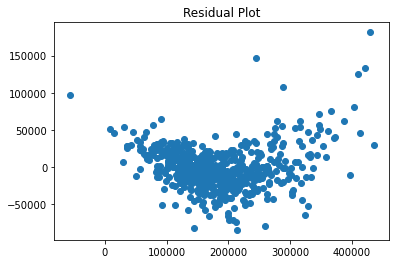

In [85]:
# plotting residual plot 
residuals = y_test - y_test_pred20
plt.scatter(y_test_pred20, residuals)
plt.title('Residual Plot');

- We can observe from the residual plot that no trends in the residual plots and observe a random pattern of points

#### 8.3 Linear Relationship 

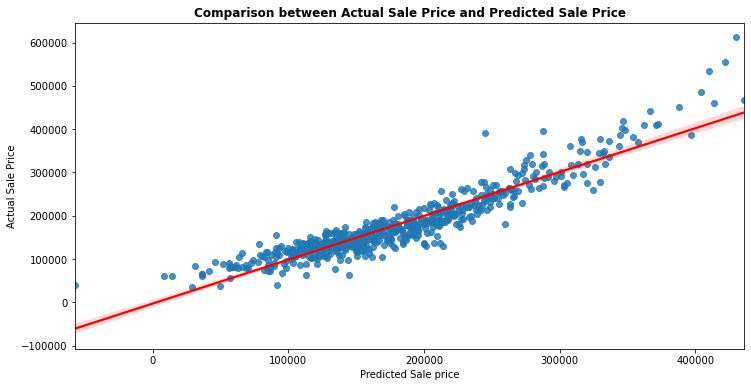

In [86]:
# Plotting regplot for Linear relationship between actual sale price and predicted sale price
plt.figure(figsize=(12,6))
sns.regplot(y_test_pred20, y_test, marker = 'o', line_kws={"color": "red"})
plt.xlabel('Predicted Sale price')
plt.ylabel('Actual Sale Price')
plt.title('Comparison between Actual Sale Price and Predicted Sale Price', fontweight = 'heavy');

- We can clearly see there is a relationship between our independent and dependent variables in the reg plot. It may not be fitted strongly at the tail end due to certian outliers but the linear relationship and the test scores are still in the acceptable range. hence we are ready to export our prediction model using ridge regression with the 20 most important features using ridge regularisation with alpha parameter 9.99.

In [87]:
# 20 most import features
X_20.columns

Index(['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Kitchen Qual',
       'Total Bsmt SF', 'Garage Area', 'Garage Cars', '1st Flr SF',
       'Bsmt Qual', 'Year Built', 'Garage Finish', 'Garage Yr Blt',
       'Year Remod/Add', 'Full Bath', 'Foundation_PConc', 'TotRms AbvGrd',
       'Mas Vnr Area', 'Fireplaces', 'BsmtFin SF 1', 'Heating QC'],
      dtype='object')

### 9. Recommendations and Conclusion

### Conclusion

We have used feature engineering, feature selection/elimination and regularization to improve our model performance. we have evaluated 3 sets of features(10, 20, 50) using linear Regression with Ridge and Lasso regularization. We also utilised the GridSearchCV tool to generate the best parameter for our regularization models. 

We have evaluated that the model with 20 most important features and using the Ridge regression with alpha:9.99 gives us the best prescriptive RMSE Score results as possible for our problem statement. 

This model will enable home owners to predict their house saleprice and the influencing features of the house which affects the Sale Price. he/she is also able to make a decision to improve/enhance these targetted features to maximise the higher potential value of their house.


### Recommendations

It is observable that from our data, the features of External Quality adds the most value to a home. this is followed by kitchen and overall quality. For Home owners should strongly target these features to improve/enhance to increase and to unlock the higher potential value of thier homes based on our predictions. 

With the presciptive values for each features, the Home owner is also able to do a cost benefit anaylsis to whether its worth forking out the initial sum to pay for the home improvement bills and seeking what value of returns. 

whilst there are some features that are not logical to enhance/improve or are unable to do so. i.e year built, Gr Liv area. we will have to filter these unlogical features out. Taking note that these features like year built, gr living area are somehow fixed and we can't change it. They are also good feature indicators for buyers to analyse and to predict the sale price value of the house. 

### 10. Export Data for Submission

In [88]:
 testset = test_df.drop(['Id'], axis =1)

In [89]:
# predict test set using the 1st model_10 features
prediction = best_model20.predict(testset[X_20.columns])

In [90]:
testset['SalePrice'] = prediction
testset['Id'] = test_df['Id']
submission_20 = testset[['Id', 'SalePrice']]

In [91]:
# submission for model
submission_20.head()

,Id,SalePrice
0,2658,145770.674757
1,2718,191181.232093
2,2414,200521.127447
3,1989,122376.332022
4,625,188579.446347


In [92]:
submission_20.to_csv('./datasets/submission.csv',index = False)
